# UC San Diego: Neural Data Science
## Stroke Prognosis with Deep Learning

## Permissions

Place an `X` in the appropriate bracket below to specify if you would like your group's project to be made available to the public. (Note that student names will be included (but PIDs will be scraped from any groups who include their PIDs).

* [X ] YES - make available
* [  ] NO - keep private

# Names

- Jaden Clarke 
- Boris Ryabov

# Overview

We got our data from the Stroke Outcome Optimization Project - they published MRI scans (both DWI and FLAIR) for more than 1700 subjects with expertly annotated lesion masks. The dataset included measures of impairment for the patients. We sought to train a model to make lesion masks which another model could use to predict the scores on those impairment measures based on the lesion

<a id='research_question'></a>
# Research Question

Can machine learning methods accurately identify regions of someones brain that have been effected by stroke and predict how their congition willl be impaired by that stroke?


<a id='background'></a>

## Background & Prior Work

    We were initially drawn to this question by a Kaggle competition that was hosted by the MAYO clinic in 2022. The STRIP (Stroke Thromboembolism Registry of Imaging and Pathology) AI competition was primarily focused on determining the origin of clots that cause strokes for the purpose of developing a prognosis. The competition was fairly recent so we sought to address a slightly different goal rather than apply more innovative methods than those that were showcased in the competition. While the kaggle competition focused on classifying strokes based on etiology, we instead focused on using image classification to identify lesions in stroke patients. Rather than classify patients based on the type of stroke that they had, we classified regions of their MRI on whether or not they were damaged. We then sought to extract features from these lesion masks that we could use to predict what the patient's score would be on the National Institute of Health Stroke Scale. Normally getting this score would involve medical personnel asking the patient a series of questions, with each question a patient accrues points based on how impaired they are. Being able to procure a score from medical imaging would massively speed up the time it takes for doctors to secure a crucial prognostic tool.


    In our process of model selection we came across the U-net. A U-net contains two main parts, the encoder (a contracting set of layers), and a decoder (an expanding set of layers). By reducing the spatial resolution of each dimension and adding new layers the encoder captures contextual information. The decoder extracts precise locality information while preserving context due to skip connections with corresponding levels of the encoder. Initially presented by Ronneberger et al. in 2015, this model was first put to the test on neuronal structures. It has since been applied to myriad medical imaging tasks, so we thought it would be a good choice for this task. Wrangling our data was a much more difficult and time consuming and difficult task than implementing this model.

    The second model that we decided to work with is Random Forest. The original paper describing an algorithm that could generate random forests was published by Tin Kam Ho in 1995. It randomly selects subsets of the overall features and generates a series of decision trees that each have their variance controlled. The model then comes to a consensus based on a plurality vote of the many trees that it has generated. Seeing as they are an ensemble of imperfect classifications, random forests are not the most accurate of models. Nonetheless, we chose random forest for our project because it is a highly transparent model and we wanted to see which feature of the stroke would be the most highly correlated with the patient's level of impairment and we have expert-ascertained ground truth available for every point in our dataset.











References (include links):
- 1)Ashley Chow, Barbaros, Ryan Holbrook, Sobhi Jabal, VikashGupta. (2022). Mayo Clinic - STRIP AI. Kaggle. https://kaggle.com/competitions/mayo-clinic-strip-ai
- 2)Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "U-net: Convolutional networks for biomedical image segmentation." Medical image computing and computer-assisted intervention–MICCAI 2015: 18th international conference, Munich, Germany, October 5-9, 2015, proceedings, part III 18. Springer International Publishing, 2015.
-3) Ho, Tin Kam (1995). Random Decision Forests (PDF). Proceedings of the 3rd International Conference on Document Analysis and Recognition, Montreal, QC, 14–16 August 1995. pp. 278–282. Archived from the original (PDF) on 17 April 2016. Retrieved 5 June 2016

# Hypothesis


We believe that a U-net and random forest can identify which part of a patient's brain has been impacted by stroke and predict how severely their cognition would be impacted by that stroke. 

# Dataset(s)

- Dataset Name: Stroke Outcome Optimization Project 
- Link to the dataset: https://openneuro.org/datasets/ds004889/versions/1.1.2
- Number of observations: It contains 13,737 files. 

Most of the files in SOOP are raw FLAIR or DWI scans, but there is a derivatives folder that just contains lesion masks and a participants.tsv that contains the impairment data. It's hosted on OpenNeuro. There are many inconsistencies in the precise dimensions of the files, but we sorted all of that out. It took more than 12 hours to download on my wifi 



In [3]:
import os
import pandas as pd
import nibabel as nib
import numpy as np
import SimpleITK as sitk
import os
import pandas as pd
import nibabel as nib
import numpy as np
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from skimage import exposure
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from skimage.transform import resize
from skimage.transform import pyramid_gaussian
from scipy.ndimage import gaussian_filter
from scipy.stats import spearmanr
from skimage.measure import regionprops
import matplotlib.pyplot as plt
import shutil
import glob
from nilearn import image as nimg
from scipy.ndimage import zoom
from mayavi import mlab

In [3]:
%pip install pandas
%pip install nibabel
%pip install numpy
%pip install SimpleITK
!pip install tensorflow
!pip install scikit-image
!pip install scikit-learn
!pip install scipy
%pip install matplotlib
%pip install pydot graphviz nilearn
%pip install mayavi

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [4]:
%pip install mayavi

# Data Wrangling

First we saved the paths to the directories containing the raw MRI scans, the patient impairment info, and the annotated traces. We then used these helper functions to load in the data. We did a quick check to make sure everything worked

In [4]:
BASE_DIR_ANN = r"C:\Users\SmotP\Downloads\final-project-data\derivatives\lesion_masks"
PATIENT = r"C:\Users\SmotP\Downloads\final-project-data\participants.tsv"
BASE_DIR_TRACE = r"C:\Users\SmotP\Downloads\final-project-data\Subs"

# Helper functions to load in our data

# Loading annotated strokes
def load_mri_data_with_stroke(base_dir):
    mri_data = {}

    for root, dirs, files in os.walk(base_dir):
        for file in files:
            if file.endswith(('.nii', '.nii.gz')):
                mri_path = os.path.join(root, file)
                try:
                    mri_img = nib.load(mri_path)
                    patient_id = os.path.basename(os.path.dirname(root))


                    if patient_id not in mri_data:
                        mri_data[patient_id] = []
                    mri_data[patient_id].append(mri_img)
                except nib.filebasedimages.ImageFileError as e:
                    print(f"Error loading file {mri_path}: {e}")
                except Exception as e:
                    print(f"Unexpected error with file {mri_path}: {e}")

    return mri_data

def load_mri_dwi_trace(dir):
    mri_data = {}

    for root, dirs, files in os.walk(dir):
        for file in files:
            if file.endswith(('.nii', '.nii.gz')):
                mri_path = os.path.join(root, file)
                if "TRACE_dwi" in mri_path:
                    try:
                        mri_img = nib.load(mri_path)
                        patient_id = os.path.basename(os.path.dirname(root))

                        if patient_id not in mri_data:
                            mri_data[patient_id] = []
                        mri_data[patient_id].append(mri_img)
                    except nib.filebasedimages.ImageFileError as e:
                        print(f"Error loading file {mri_path}: {e}")
                    except Exception as e:
                        print(f"Unexpected error with file {mri_path}: {e}")

    return mri_data

    # Load patient data
def load_patient_data(file_path):
    try:
        return pd.read_csv(file_path, sep='\t')
    except Exception as e:
        print(f"Error loading pacient data from {file_path}: {e}")
        return None


annotated_stroke_data = load_mri_data_with_stroke(BASE_DIR_ANN)
mri_trace = load_mri_dwi_trace(BASE_DIR_TRACE)
patients = load_patient_data(PATIENT)

# Check sanity of data
if patients.empty:
    print("No pacient data found found")

if len(annotated_stroke_data) == 0:
    print("Annotated strokes are empty")
patients

,participant_id,sex,age,race,acuteischaemicstroke,priorstroke,bmi,nihss,gs_rankin_6isdeath,etiology
0,sub-2,M,78,w,1.0,0.0,22.84,17.0,NaN,"2: Cardioembolism (e.g., atrial fibrillation/f..."
1,sub-3,F,87,w,1.0,1.0,19.23,15.0,6.0,5: Cryptogenic Stroke
2,sub-5,M,58,w,1.0,0.0,37.29,1.0,NaN,"3: Small-vessel disease (e.g., Subcortical or ..."
3,sub-6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,sub-7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1500,sub-1730,M,57,w,1.0,0.0,25.71,0.0,1.0,5: Cryptogenic Stroke
1501,sub-1731,F,52,b,1.0,1.0,16.63,12.0,4.0,"2: Cardioembolism (e.g., atrial fibrillation/f..."
1502,sub-1734,F,79,w,1.0,0.0,30.47,1.0,NaN,5: Cryptogenic Stroke
1503,sub-1735,F,65,w,1.0,0.0,48.05,4.0,4.0,"1: Large-artery atherosclerosis (e.g., carotid..."


# Data Cleaning

We dropped na values because we could only use patients that had data for every field in the database for our analysis. After that we normalized the MRI data (for the first time) by resclaing the intensity of the images and smoothing via applciation of a Gaussian filter

In [5]:
patients = patients.dropna().reset_index(drop=True)
patients

# Leave only subject that are present in all three datasets
keys_ann = list(annotated_stroke_data)
keys_mri = list(mri_trace)
keys_pacients = list(patients.participant_id)

total = keys_ann + keys_mri + keys_pacients

for sub in total:
   if not (sub in keys_ann and sub in keys_mri and sub in keys_pacients):

      if sub in annotated_stroke_data:
         annotated_stroke_data.pop(sub)

      if sub in mri_trace:
         mri_trace.pop(sub)

      if sub in list(patients.participant_id):
         patients = patients[patients.participant_id != sub]

patients = patients.reset_index(drop=True)
patients



def preprocess_mri_data(mri_data, output_dir, output_dtype=np.float64):
    """
    Preprocesses MRI data by normalizing intensity and applying Gaussian smoothing.

    Parameters:
        mri_data (dict): A dictionary where keys are patient IDs and values are lists of MRI images.
        output_dir (str): The directory where preprocessed MRI images will be saved.
        output_dtype (numpy.dtype, optional): The data type to which the MRI images will be converted during preprocessing. 
                                                Defaults to np.float64.

    Returns:
        dict: A dictionary where keys are patient IDs and values are lists of paths to preprocessed MRI images.
    """
    preprocessed_mri_data = {}
    
    for patient_id, mri_img in mri_data.items():
        preprocessed_images = []
        
        for img_idx, img in enumerate(mri_img):
            img = img.get_fdata().astype(output_dtype)
            
            # Intensity normalization
            normalized_data = exposure.rescale_intensity(img, out_range=(0, 1))
            
            # Apply noise reduction (e.g., Gaussian smoothing)
            smoothed_data = gaussian_filter(normalized_data, sigma=1)
            
            # Save preprocessed image to disk
            output_path = os.path.join(output_dir, f"{patient_id}_{img_idx}.npy")
            np.save(output_path, smoothed_data)
            
            preprocessed_images.append(output_path)
        
        preprocessed_mri_data[patient_id] = preprocessed_images
    return preprocessed_mri_data

preprocessed_trace = preprocess_mri_data(mri_trace, output_dir = r"C:\Users\SmotP\Downloads\final-project-data\pre_processed_mri")

This is where we got all of the MRI scans into the same size array

In [7]:
def standardize_images(image_dict, target_shape):
    standardized_images = {}
    
    for subject, images in image_dict.items():
        for image in images:
            current_shape = image.shape
            print(f"Processing subject: {subject}, Current shape: {current_shape}")
            
            # Check if the image has the same number of dimensions as the target shape
            if len(current_shape) != len(target_shape):
                raise ValueError(f"Image shape {current_shape} for subject {subject} does not match target shape {target_shape}")
            
            # Determine the zoom factor for each dimension
            zoom_factors = [target_dim / current_dim for target_dim, current_dim in zip(target_shape, current_shape)]
            
            # Apply the zoom to resize the image
            standardized_image = zoom(image, zoom_factors, order=3)  # Using cubic interpolation (order=3)
            
            standardized_images[subject] = standardized_image

            output_dir = r"C:\Users\SmotP\Downloads\final-project-data\standardized images"
            output_path = os.path.join(output_dir, f"{subject}.png")
            np.save(output_path, standardized_image)
    
    return standardized_images

# Data Visualization

At this point the only thing we really have to visualize is the ground truth stroke lesions and the MRI scans of the patients 

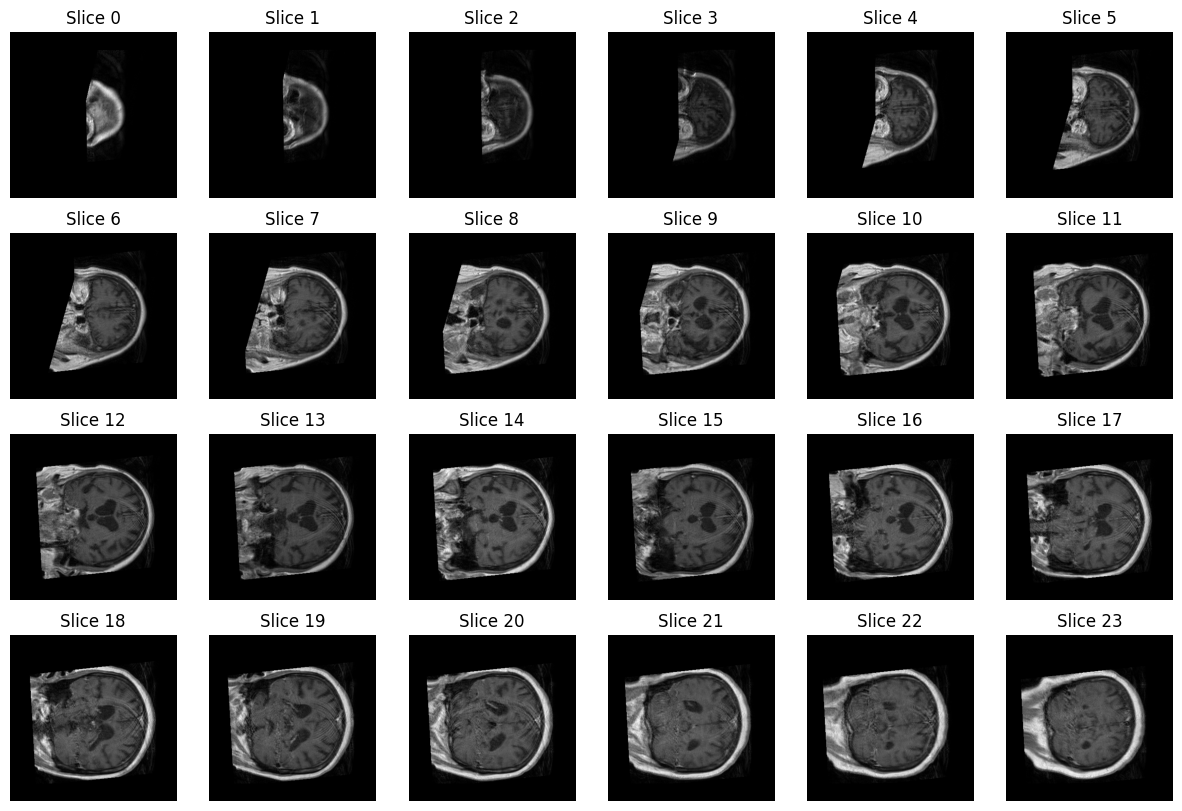

In [8]:
def visualize_nifti_image(nifti_file_path):
    """
    Visualize a NIfTI image.

    Args:
        nifti_file_path (str): Path to the NIfTI file.

    """
    # Load the NIfTI image
    img = nib.load(nifti_file_path)
    data = img.get_fdata()
    data = (data - data.min()) / (data.max() - data.min())

    # Display 24 slices of the image
    num_slices = min(24, data.shape[-1])  # Limit to 24 slices or the number of available slices
    fig, axs = plt.subplots(4, 6, figsize=(15, 10))

    for i in range(num_slices):
        row = i // 6
        col = i % 6
        axs[row, col].imshow(data[:, :, i], cmap='gray')
        axs[row, col].axis('off')
        axs[row, col].set_title(f"Slice {i}")

    # Hide any unused subplot axes
    for j in range(num_slices, 24):
        row = j // 6
        col = j % 6
        axs[row, col].axis('off')

    plt.show()

mri_file_path = r"C:\Users\SmotP\Downloads\final-project-data\sub-99\anat\sub-99_T1w.nii.gz"



visualize_nifti_image(mri_file_path)


# Data Analysis & Results

* Include cells that describe the steps in your data analysis.
* You'll likely also have some visualizations here as well.

In [9]:
def extract_stroke_features(segmented_damage_dict):
    """
    Extract stroke features from segmented damage data.

    Args:
        segmented_damage_dict (dict): A dictionary where keys are patient IDs and values are lists of NumPy arrays
                                      representing segmented stroke damage.

    Returns:
        dict: A dictionary where keys are patient IDs and values are dictionaries containing stroke features.
    """
    features_dict = {}
    for patient_id, segmented_damage_list in segmented_damage_dict.items():
        features_list = []
        for segmented_damage in segmented_damage_list:
            # Calculate volume (number of non-zero voxels)
            volume = np.sum(segmented_damage != 0)

            # Calculate centroid coordinates
            props = regionprops(segmented_damage.astype(int))
            centroid = props[0].centroid

            # Calculate bounding box dimensions
            min_row, min_col, min_slice, max_row, max_col, max_slice = props[0].bbox
            bounding_box_dimensions = (max_row - min_row, max_col - min_col, max_slice - min_slice)

            # Calculate intensity statistics
            intensity_mean = np.mean(segmented_damage)
            intensity_std = np.std(segmented_damage)

            features = {
                'volume': volume,
                'centroid': centroid,
                'bounding_box_dimensions': bounding_box_dimensions,
                'intensity_mean': intensity_mean,
                'intensity_std': intensity_std
            }
            features_list.append(features)

        features_dict[patient_id] = features_list

    return features_dict

In [10]:
import zipfile

zip_path = r"C:\Users\SmotP\Downloads\standardized_images.zip"
extract_folder = r"C:\Users\SmotP\Downloads\standardized_images"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

train_data_dir = os.path.join(extract_folder, "images")
train_label_dir = os.path.join(extract_folder, "labels")

In [12]:
imgs = np.load(r"C:\Users\SmotP\Downloads\standardized_images.zip")


# Load the .npz file
npz_file = np.load(r"C:\Users\SmotP\Downloads\standardized_images.zip")

# Check the keys in the .npz file
print("Keys in the .npz file:", npz_file.files)




Keys in the .npz file: ['standardized_images/', 'standardized_images/sub-933.png', 'standardized_images/sub-599.png', 'standardized_images/sub-375.png', 'standardized_images/sub-1232.png', 'standardized_images/sub-458.png', 'standardized_images/sub-1669.png', 'standardized_images/sub-1701.png', 'standardized_images/sub-656.png', 'standardized_images/sub-1144.png', 'standardized_images/sub-634.png', 'standardized_images/sub-542.png', 'standardized_images/sub-1338.png', 'standardized_images/sub-73.png', 'standardized_images/sub-1391.png', 'standardized_images/sub-701.png', 'standardized_images/sub-1646.png', 'standardized_images/sub-1013.png', 'standardized_images/sub-1375.png', 'standardized_images/sub-467.png', 'standardized_images/sub-97.png', 'standardized_images/sub-477.png', 'standardized_images/sub-806.png', 'standardized_images/sub-328.png', 'standardized_images/sub-338.png', 'standardized_images/sub-136.png', 'standardized_images/sub-1109.png', 'standardized_images/sub-763.png',

In [13]:
def data_generator(image_generator, label_generator):
    while True:
        images = next(image_generator)
        labels = next(label_generator)
        yield (images, labels)

# Image and label directories
train_data_dir = r"C:\Users\SmotP\Downloads\standardized_images"
train_label_dir = r"C:\Users\SmotP\Downloads\final-project-data\Lesion_mask_npy"

# Image properties
image_height, image_width = (64, 64)
batch_size = 32
channels = 1
target_size = (image_height, image_width, channels)

# Create ImageDataGenerator instances
image_datagen = ImageDataGenerator(rescale=1./255)
label_datagen = ImageDataGenerator(rescale=1./255)  

image_generator = image_datagen.flow_from_directory(
    train_data_dir,
    target_size=target_size,
    batch_size=batch_size,
    color_mode='grayscale',  
    class_mode=None,
    shuffle=True
)

label_generator = label_datagen.flow_from_directory(
    train_label_dir,
    target_size=target_size,
    batch_size=batch_size,
    color_mode='grayscale',  
    class_mode=None,
    shuffle=True
)

train_generator = data_generator(image_generator, label_generator)




Found 0 images belonging to 1 classes.


Found 0 images belonging to 0 classes.


In [14]:
# Model setup
input_shape = (64,64,1)
model = unet_model(input_shape)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Training setup
num_epochs = 50  # Define the number of epochs
num_train_samples = 1000  # Define the number of training samples

# Train the model
model.fit(train_generator, epochs=num_epochs, steps_per_epoch=num_train_samples // batch_size)

Original input shape: (None, 64, 64, 1)
After initial conv (to 64 channels): (None, 64, 64, 64)
After pool1: (None, 32, 32, 64)
After pool2: (None, 16, 16, 128)
After pool3: (None, 8, 8, 256)
After pool4: (None, 4, 4, 512)
Bottleneck conv5: (None, 4, 4, 1024)
After up6: (None, 8, 8, 512)
After up7: (None, 16, 16, 256)
After up8: (None, 32, 32, 128)
After up9: (None, 64, 64, 64)
Final conv10: (None, 64, 64, 1)
Epoch 1/50


InvalidArgumentError: Graph execution error:

Detected at node StatefulPartitionedCall/functional_1_1/conv2d_1_2/Relu defined at (most recent call last):
<stack traces unavailable>
input depth must be evenly divisible by filter depth: 1 vs 64
	 [[{{node StatefulPartitionedCall/functional_1_1/conv2d_1_2/Relu}}]] [Op:__inference_one_step_on_iterator_8340]

# Data Cleaning

We dropped na values because we could only use patients that had data for every field in the database for our analysis. After that we normalized the MRI data (for the first time) by resclaing the intensity of the images and smoothing via applciation of a Gaussian filter

In [6]:
patients = patients.dropna().reset_index(drop=True)
patients

# Leave only subject that are present in all three datasets
keys_ann = list(annotated_stroke_data)
keys_mri = list(mri_trace)
keys_pacients = list(patients.participant_id)

total = keys_ann + keys_mri + keys_pacients

for sub in total:
   if not (sub in keys_ann and sub in keys_mri and sub in keys_pacients):

      if sub in annotated_stroke_data:
         annotated_stroke_data.pop(sub)

      if sub in mri_trace:
         mri_trace.pop(sub)

      if sub in list(patients.participant_id):
         patients = patients[patients.participant_id != sub]

patients = patients.reset_index(drop=True)
patients



def preprocess_mri_data(mri_data, output_dir, output_dtype=np.float64):
    """
    Preprocesses MRI data by normalizing intensity and applying Gaussian smoothing.

    Parameters:
        mri_data (dict): A dictionary where keys are patient IDs and values are lists of MRI images.
        output_dir (str): The directory where preprocessed MRI images will be saved.
        output_dtype (numpy.dtype, optional): The data type to which the MRI images will be converted during preprocessing. 
                                                Defaults to np.float64.

    Returns:
        dict: A dictionary where keys are patient IDs and values are lists of paths to preprocessed MRI images.
    """
    preprocessed_mri_data = {}
    
    for patient_id, mri_img in mri_data.items():
        preprocessed_images = []
        
        for img_idx, img in enumerate(mri_img):
            img = img.get_fdata().astype(output_dtype)
            
            # Intensity normalization
            normalized_data = exposure.rescale_intensity(img, out_range=(0, 1))
            
            # Apply noise reduction (e.g., Gaussian smoothing)
            smoothed_data = gaussian_filter(normalized_data, sigma=1)
            
            # Save preprocessed image to disk
            output_path = os.path.join(output_dir, f"{patient_id}_{img_idx}.npy")
            np.save(output_path, smoothed_data)
            
            preprocessed_images.append(output_path)
        
        preprocessed_mri_data[patient_id] = preprocessed_images
    return preprocessed_mri_data

preprocessed_trace = preprocess_mri_data(mri_trace, output_dir = r"C:\Users\SmotP\Downloads\final-project-data\pre_processed_mri") 


In [7]:
patients

,participant_id,sex,age,race,acuteischaemicstroke,priorstroke,bmi,nihss,gs_rankin_6isdeath,etiology
0,sub-3,F,87,w,1.0,1.0,19.23,15.0,6.0,5: Cryptogenic Stroke
1,sub-9,F,70,w,1.0,0.0,26.89,18.0,4.0,"1: Large-artery atherosclerosis (e.g., carotid..."
2,sub-13,M,73,w,1.0,0.0,33.77,0.0,0.0,"1: Large-artery atherosclerosis (e.g., carotid..."
3,sub-17,M,72,w,1.0,0.0,30.48,0.0,2.0,"3: Small-vessel disease (e.g., Subcortical or ..."
4,sub-19,F,43,w,1.0,1.0,20.96,0.0,0.0,5: Cryptogenic Stroke
...,...,...,...,...,...,...,...,...,...,...
550,sub-1723,F,61,w,1.0,0.0,25.45,4.0,2.0,5: Cryptogenic Stroke
551,sub-1725,M,69,w,1.0,0.0,40.83,24.0,5.0,5: Cryptogenic Stroke
552,sub-1731,F,52,b,1.0,1.0,16.63,12.0,4.0,"2: Cardioembolism (e.g., atrial fibrillation/f..."
553,sub-1735,F,65,w,1.0,0.0,48.05,4.0,4.0,"1: Large-artery atherosclerosis (e.g., carotid..."


This is where we got all of the MRI scans into the same size array

In [ ]:
def standardize_images(image_dict, target_shape):
    standardized_images = {}
    
    for subject, images in image_dict.items():
        for image in images:
            current_shape = image.shape
            print(f"Processing subject: {subject}, Current shape: {current_shape}")
            
            # Check if the image has the same number of dimensions as the target shape
            if len(current_shape) != len(target_shape):
                raise ValueError(f"Image shape {current_shape} for subject {subject} does not match target shape {target_shape}")
            
            # Determine the zoom factor for each dimension
            zoom_factors = [target_dim / current_dim for target_dim, current_dim in zip(target_shape, current_shape)]
            
            # Apply the zoom to resize the image
            standardized_image = zoom(image, zoom_factors, order=3)  # Using cubic interpolation (order=3)
            
            standardized_images[subject] = standardized_image

            output_dir = r"C:\Users\SmotP\Downloads\final-project-data\standardized images"
            output_path = os.path.join(output_dir, f"{subject}.png")
            np.save(output_path, standardized_image)
    
    return standardized_images

# Data Visualization

At this point the only thing we really have to visualize is the ground truth stroke lesions and the MRI scans of the patients 

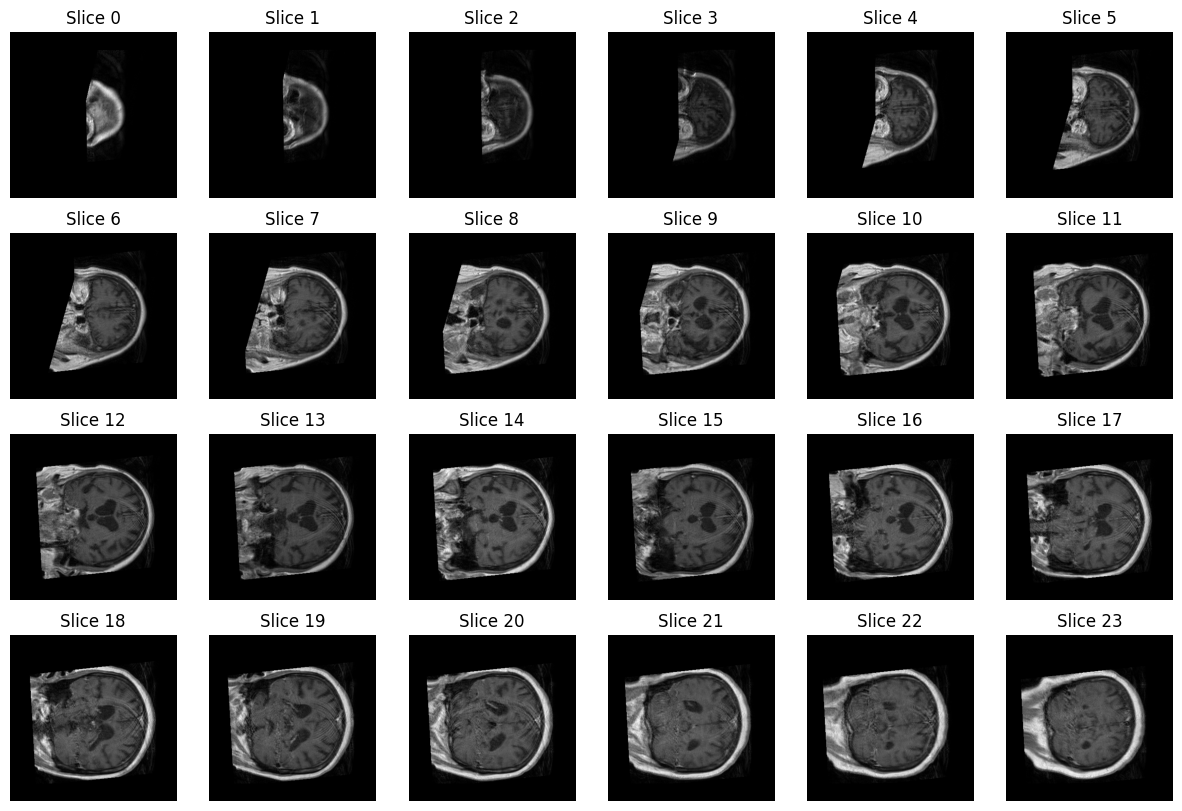

In [ ]:
def visualize_nifti_image(nifti_file_path):
    """
    Visualize a NIfTI image.

    Args:
        nifti_file_path (str): Path to the NIfTI file.

    """
    # Load the NIfTI image
    img = nib.load(nifti_file_path)
    data = img.get_fdata()
    data = (data - data.min()) / (data.max() - data.min())

    # Display 24 slices of the image
    num_slices = min(24, data.shape[-1])  # Limit to 24 slices or the number of available slices
    fig, axs = plt.subplots(4, 6, figsize=(15, 10))

    for i in range(num_slices):
        row = i // 6
        col = i % 6
        axs[row, col].imshow(data[:, :, i], cmap='gray')
        axs[row, col].axis('off')
        axs[row, col].set_title(f"Slice {i}")

    # Hide any unused subplot axes
    for j in range(num_slices, 24):
        row = j // 6
        col = j % 6
        axs[row, col].axis('off')

    plt.show()

mri_file_path = r"C:\Users\SmotP\Downloads\final-project-data\sub-99\anat\sub-99_T1w.nii.gz"



visualize_nifti_image(mri_file_path)


# Data Analysis & Results

* Include cells that describe the steps in your data analysis.
* You'll likely also have some visualizations here as well.

In [5]:
def unet_model(input_shape, num_features):
    # Define encoder (downsampling) path
    inputs = layers.Input(input_shape)
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(conv4)
    pool4 = layers.MaxPooling2D(pool_size=(2, 2))(conv4)
    
    # Bottleneck
    conv5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(conv5)
    
    # Include additional features as input
    feature_inputs = layers.Input((num_features,))
    combined = layers.concatenate([layers.Flatten()(conv5), feature_inputs])
    combined_dense = layers.Dense(1024, activation='relu')(combined)
    combined_reshaped = layers.Reshape((1, 1, 1024))(combined_dense)

    # Define decoder (upsampling) path with skip connections
    up6 = layers.Conv2DTranspose(512, 3, strides=(2, 2), activation='relu', padding='same')(combined_reshaped)
    merge6 = layers.concatenate([conv4, up6], axis=3)
    conv6 = layers.Conv2D(512, 3, activation='relu', padding='same')(merge6)
    conv6 = layers.Conv2D(512, 3, activation='relu', padding='same')(conv6)
    
    up7 = layers.Conv2DTranspose(256, 3, strides=(2, 2), activation='relu', padding='same')(conv6)
    merge7 = layers.concatenate([conv3, up7], axis=3)
    conv7 = layers.Conv2D(256, 3, activation='relu', padding='same')(merge7)
    conv7 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv7)
    
    up8 = layers.Conv2DTranspose(128, 3, strides=(2, 2), activation='relu', padding='same')(conv7)
    merge8 = layers.concatenate([conv2, up8], axis=3)
    conv8 = layers.Conv2D(128, 3, activation='relu', padding='same')(merge8)
    conv8 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv8)
    
    up9 = layers.Conv2DTranspose(64, 3, strides=(2, 2), activation='relu', padding='same')(conv8)
    merge9 = layers.concatenate([conv1, up9], axis=3)
    conv9 = layers.Conv2D(64, 3, activation='relu', padding='same')(merge9)
    conv9 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv9)
    
    conv10 = layers.Conv2D(1, 1, activation='sigmoid')(conv9)

    model = models.Model(inputs=[inputs, feature_inputs], outputs=conv10)

    return model

In [6]:
model = unet_model((240,24,3), 1200)

model.summary

ValueError: A `Concatenate` layer requires inputs with matching shapes except for the concatenation axis. Received: input_shape=[(None, 30, 3, 512), (None, 2, 2, 512)]

In [ ]:
# Assuming preprocessed_trace and annotated_stroke_data are given
preprocessed_mri_data = np.array([np.array(trace) for trace in preprocessed_trace])

annotated_stroke_dir = r"C:\Users\SmotP\Documents\COGS 138\Lesion_mask_npy"
annotated_stroke_data = []

# Load all files in the directory
for file_name in os.listdir(annotated_stroke_dir):
    file_path = os.path.join(annotated_stroke_dir, file_name)
    data = np.load(file_path)
    annotated_stroke_data.append(data)

# Ensure all arrays have the same shape
min_shape = min(array.shape for array in annotated_stroke_data)

def slice_array(array, target_shape): 
    result = np.zeros(target_shape)
    slices = tuple(slice(0, min(dim, target)) for dim, target in zip(array.shape, target_shape))
    result[slices] = array[slices]
    return result

annotated_stroke_data = np.array([slice_array(array, min_shape) for array in annotated_stroke_data])

# Check the shapes of the data
print("Shape of preprocessed_mri_data:", preprocessed_mri_data.shape)
print("Shape of annotated_stroke_data:", annotated_stroke_data.shape)

# Ensure annotated_stroke_data has the same number of samples
if preprocessed_mri_data.shape[0] != annotated_stroke_data.shape[0]:
    raise ValueError("Mismatch in number of samples between MRI data and annotated stroke data.")

# Reshape the data if necessary
input_shape = preprocessed_mri_data.shape[1:]  # Assuming the data is in the shape (num_samples, height, width, channels)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(preprocessed_mri_data, annotated_stroke_data, test_size=0.2, random_state=42)

# Define UNet model (assuming unet_model is defined elsewhere)
model = unet_model(input_shape)

# Compile the model
model.compile(optimizer=Adam(), loss=BinaryCrossentropy(), metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=16, validation_data=(X_val, y_val))

# Evaluate the model
loss, accuracy = model.evaluate(X_val, y_val)
print("Validation Loss:", loss)
print("Validation Accuracy:", accuracy)

# Visualize the model architecture
plot_model(model, to_file='unet_model.png', show_shapes=True, show_layer_names=True)

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'])

MemoryError: Unable to allocate 5.74 MiB for an array with shape (1505280,) and data type int32

In [8]:
impairment_data = patients[['nihss', 'participant_id']]

impairment_data

,nihss,participant_id
0,15.0,sub-3
1,18.0,sub-9
2,0.0,sub-13
3,0.0,sub-17
4,0.0,sub-19
...,...,...
550,4.0,sub-1723
551,24.0,sub-1725
552,12.0,sub-1731
553,4.0,sub-1735


In [9]:
# Directory containing the raw MRI files
raw_mri_dir = r"C:\Users\SmotP\Downloads\standardized_images\standardized_images"

# Initialize lists to store MRI data and subject names
raw_mri = []
subject_names = []

# Load all files in the directory
for file_name in os.listdir(raw_mri_dir):
    if file_name.endswith('.npy'):  # Ensure only .npy files are processed
        file_path = os.path.join(raw_mri_dir, file_name)
        data = np.load(file_path)
        raw_mri.append(data)
        
        # Extract subject name from file name (assuming file name format includes subject name)
        subject_name = file_name.split('.')[0]  # Adjust based on actual file name format
        subject_names.append(subject_name)

# Convert lists to numpy arrays
raw_mri = np.array(raw_mri)
subject_names = np.array(subject_names)

# Assuming impairment_data is a pandas DataFrame with a column 'participant_id' for subject names
impairment_data.set_index('participant_id', inplace=True)

# Match MRI data with impairment scores based on subject names
matched_indices = [i for i, name in enumerate(subject_names) if name in impairment_data.index]
matched_subject_names = [name for name in subject_names if name in impairment_data.index]

# Filter raw_mri to only include matched subjects
raw_mri = raw_mri[matched_indices]

# Reindex impairment_data to match the order of subject_names in raw_mri
impairment_data = impairment_data.reindex(matched_subject_names)

# Ensure the number of samples matches
if raw_mri.shape[0] != impairment_data.shape[0]:
    raise ValueError("Mismatch in number of samples between MRI data and impairment data.")

# Reshape raw_mri if necessary
raw_mri = raw_mri.reshape((impairment_data.shape[0], -1))  # Flatten the data for training

In [10]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(raw_mri, impairment_data['nihss'], test_size=0.2, random_state=42)

# Train Random Forest regressor
def train_random_forest(X_train, y_train):
    rf_regressor = RandomForestRegressor(random_state=42)
    rf_regressor.fit(X_train, y_train)
    return rf_regressor

In [11]:

# Tune hyperparameters (assuming a function tune_hyperparameters is defined)
def tune_hyperparameters(model, X_train, y_train):
    from sklearn.model_selection import GridSearchCV

    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2],
    }

    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
    grid_search.fit(X_train, y_train)
    return grid_search.best_params_



In [12]:
#train forest
rf_regressor = train_random_forest(X_train, y_train)



In [ ]:
# Tune hyperparameters
best_params = tune_hyperparameters(rf_regressor, X_train, y_train)

In [ ]:

# Initialize and train the Random Forest regressor with best parameters
rf_regressor_best = RandomForestRegressor(**best_params, random_state=42)
rf_regressor_best.fit(X_train, y_train)

# Predict on the test set
y_pred_best = rf_regressor_best.predict(X_test)

# Evaluate the model
mse_best = mean_squared_error(y_test, y_pred_best)
print("Mean Squared Error:", mse_best)

# Conclusion & Discussion

* Discussion of your results and how they address your experimental question(s).
* Discussed limitations of your analyses.
* You can also discuss future directions you'd like to pursue.

We could do a lot more with feature extraction form our stroke feature extraction process and hyperparameter tuning. Exploring the documentation for skimage imageprops and making a hypermodel for our U-net would be great places to start

In [ ]:
rf_regressor, X_train_features, y_train = train_random_forest(raw_mri, impairment_data)

# Tune hyperparameters
best_params = tune_hyperparameters(rf_regressor, X_train_features, y_train)

# Initialize and train the Random Forest regressor with best parameters
rf_regressor_best = RandomForestRegressor(**best_params, random_state=42)
rf_regressor_best.fit(X_train_features, y_train)

y_pred_best = rf_regressor_best.predict(X_test_features)

# Evaluate the model
mse_best = mean_squared_error(y_test, y_pred_best)

# Conclusion & Discussion

* Discussion of your results and how they address your experimental question(s).
* Discussed limitations of your analyses.
* You can also discuss future directions you'd like to pursue.

We could do a lot more with feature extraction form our stroke feature extraction process and hyperparameter tuning. Exploring the documentation for skimage imageprops and making a hypermodel for our U-net would be great places to start